<a href="https://colab.research.google.com/github/i-m-vivek/Deep-Learning-Models/blob/master/Image_to_Vector_EyeGaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output

In [2]:
!nvidia-smi

Mon Jun 15 20:45:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image to Vector

**Task :** Given an image only we need to predict the gazing vector.
**Dataset :** We used the train set of OpenEDS Challenge for each sequence 10 frames are sampled at an interval of 10.

In [0]:
from IPython.display import clear_output
!unrar x "/content/drive/My Drive/EyeGaze/data/Complete Data Resized/resized_complete_train.rar"
!unrar x "/content/drive/My Drive/EyeGaze/data/Complete Data Resized/resized_complete_val.rar"
clear_output()

## Dataloaders

In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import tqdm
import pandas as pd 
import cv2 as cv
import numpy as np 
from PIL import Image
from skimage import io, transform
import time
import os
import copy

In [0]:
experiment = Experiment(api_key="aStTk6RcTdEOiaQHAVz0Oduej",
                        project_name="eyegaze", workspace="vivek-mittal")

In [0]:
class EyeGazeDataset(Dataset):
    def __init__(self, root_dir, df, transform= None):
        self.root_dir = root_dir 
        self.df = df.sample(frac= 1)
        self.transform = transform
    def __getitem__(self, idx):
        vector  = np.array(self.df.iloc[idx, 1:] , dtype= np.float64)
        # img = io.imread(os.path.join(self.root_dir, self.df.iloc[idx, 0]))

        img = cv.imread(os.path.join(self.root_dir, self.df.iloc[idx, 0]))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, vector
    def __len__(self):
        return len(self.df)

In [0]:
train = pd.read_csv("/content/image_vector_data/image_to_vector.csv")
val = pd.read_csv("/content/val/image_to_vector_val.csv")

In [0]:
BS = 16

In [0]:
composed_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

train_dataset= EyeGazeDataset("/content/image_vector_data/train", train, composed_transform)
val_dataset= EyeGazeDataset("/content/val/validation", val, composed_transform)

image_datasets = {"train": train_dataset ,
                  "val":val_dataset }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BS,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [0]:
dataset_sizes

{'train': 12800, 'val': 6400}

In [0]:
experiment.set_name("ResNet18 Again using prev. (with which .0031) params for 50 epochs")

## Loss Function

In [0]:
def acos_loss(pred, true):
    """
    Expected shape for true and pred is (m, 3)
    where m is the batchsize and 3 are the x, y, z coordinates
    """
    bs = pred.size(0)
    batch_dot_product = torch.bmm(pred.view(bs, 1, 3), true.view(bs, 3, 1)).reshape(bs, )
    norm_true= torch.norm(true, p= 2, dim= -1)
    norm_pred= torch.norm(pred, p= 2, dim= -1)

    loss = torch.mean(torch.acos(batch_dot_product/(norm_true*norm_pred)))
    return loss

## Model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def train_model(model, optimizer, num_epochs=25, criterion= None, scheduler= None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 99999

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if criterion is not None:
                        loss = criterion(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                    else:
                        loss = acos_loss(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val' and scheduler != None:
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss

### ResNet 50

In [0]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)
criterion = nn.MSELoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
Etorch.save({
    "Epoch": 20, 
    "loss":best_loss,
    "loss_function": "acos_loss",
    "Model": "ResNet50", 
    "train_data & val_data": "As provided for challenge i.e. both are different",
    "model": model_ft.state_dict(), 
    "optimizer":optimizer_ft.state_dict() ,
}, "/content/drive/My Drive/EyeGaze/checkpoint_resnet50_acosLoss_20epochs.pth")

### ResNet 18

In [0]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)

In [0]:
num_epochs = 50

In [0]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 99999

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                # if criterion is not None:
                #     loss = criterion(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                # else:
                loss = acos_loss(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                    
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
        

        epoch_loss = running_loss / dataset_sizes[phase]
        if phase == 'val' and scheduler != None:
            scheduler.step(epoch_loss)

        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/49
----------



train Loss: 0.1616



val Loss: 0.1767

Epoch 1/49
----------


In [0]:
torch.save({
    "Epoch": 50, 
    "loss":best_loss,
    "loss_function": "acos_loss",
    "Model": "ResNet18", 
    "BS": BS,
    "train_data & val_data": "As provided for challenge i.e. both are different",
    "model": model.state_dict(), 
    "optimizer":optimizer.state_dict() ,
    "scheduler": scheduler.state_dict(),
}, "/content/drive/My Drive/EyeGaze/checkpoint_resnet18_acosLoss_50epochs_new.pth", )

### ResNet 152

In [0]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
hyper_params = {
    "batch_size": 4,
    "num_epochs": 10,
    "model_name": "ResNet152",
    "initial_learning_rate": 0.003,
    "scheduler": "ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)",
    "weight_decay":.0001,
    "Loss Function": "acos_loss"
}
experiment.log_parameters(hyper_params)

In [0]:
num_epochs = 10

In [0]:
sample = (iter(dataloaders["train"])).next()

In [0]:
sample

In [0]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 99999


with experiment.train():
    train_step = 0
    val_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # if criterion is not None:
                    #     loss = criterion(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                    # else:
                    loss = acos_loss(outputs.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # train and val are treated differently 
                if phase == "train":
                    train_step += 1
                    experiment.log_metric("train_batch_loss", loss.item(), train_step)
                elif phase == "val":
                    val_step += 1
                    experiment.log_metric("val_batch_loss", loss.item(), val_step)

            

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                experiment.log_metric("train_batch_loss", loss.item(), epoch)
            elif phase == "val":
                experiment.log_metric("val_batch_loss", loss.item(), epoch)
            if phase == 'val' and scheduler != None:
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/9
----------



train Loss: 0.2371



val Loss: 0.2379

Epoch 1/9
----------



train Loss: 0.2220



val Loss: 0.2696

Epoch 2/9
----------



train Loss: 0.2208



val Loss: 0.2253

Epoch 3/9
----------



train Loss: 0.2160



val Loss: 0.2162

Epoch 4/9
----------



train Loss: 0.2064



val Loss: 0.2308

Epoch 5/9
----------



train Loss: 0.2084


In [0]:
torch.save({
    "Epoch": 10, 
    "loss":best_loss,
    "loss_function": "acos_loss",
    "Model": "ResNet152", 
    "train_data & val_data": "As provided for challenge i.e. both are different",
    "model": model.state_dict(), 
    "optimizer":optimizer.state_dict() ,
    "scheduler": scheduler.state_dict(),
}, "/content/drive/My Drive/EyeGaze/checkpoint_resnet152_acosLoss_10epochs.pth")

## Some Testing

In [0]:
def imshow(img):
    img = img.squeeze().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [0]:
sample_loader =  torch.utils.data.DataLoader(image_datasets["val"], batch_size=1, shuffle=True, num_workers=4)
sample_iter = iter(sample_loader)
model.eval()

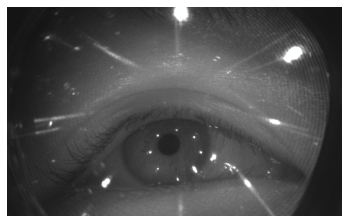

Loss : tensor(0.1067)
Preds:  [[-0.14078914  0.11198509  0.97615486]]
True:  [[-0.24644085  0.11180214  0.96268748]]


In [0]:
sample = sample_iter.next()
imshow(sample[0])
sample_preds= model(sample[0].to(device))
print("Loss :", acos_loss(sample_preds.detach().cpu().float(), sample[1].float()))
print("Preds: ", sample_preds.detach().cpu().numpy())
print("True: ", sample[1].numpy())

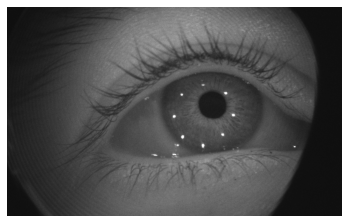

Loss : tensor(0.0480)
Preds:  [[0.1995648  0.08703633 0.9823574 ]]
True:  [[0.16586159 0.05219962 0.98476654]]


In [0]:
sample = sample_iter.next()
imshow(sample[0])
sample_preds= model(sample[0].to(device))
print("Loss :", acos_loss(sample_preds.detach().cpu().float(), sample[1].float()))
print("Preds: ", sample_preds.detach().cpu().numpy())
print("True: ", sample[1].numpy())

In [0]:
# Clearly the model in not working well on images with lens

In [0]:
experiment.end()